In [25]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import scipy as sp # type: ignore
from scipy.optimize import curve_fit # type: ignore
import matplotlib.pyplot as plt # type: ignore

# UNITS
ev2au = 1/27.211396132
au2ev = 27.211396132
ang2au = 1/0.529177249
au2ang = 0.529177249
au2fs = 1/41.34137333656
fs2au = 41.34137333656
au2debye = 1/0.39343
debye2au = 0.39343
au2nm = 0.052917720859
nm2au = 1/0.052917720859
au2cm1 = 2.1947463137E5
cm12au = 1/(2.1947463137E5)
au2amu = 1/1822.88848325
amu2au = 1822.88848325
thz2au = 1.0/0.029979/au2cm1

#La suma debe ser una suma de 32 terminos

coeff_matrix = np.zeros((32,4))
coeff_matrix[0,:] = [0,0,1,32849.58]
coeff_matrix[1,:] = [0,1,1,-17553.99]
coeff_matrix[2,:] = [1,0,1,-27625.23]
coeff_matrix[3,:] = [2,0,0,50043.09]
coeff_matrix[4,:] = [4,0,0,336.49]
coeff_matrix[5,:] = [0,1,2,-3360.94]
coeff_matrix[6,:] = [0,3,0,-64.84]
coeff_matrix[7,:] = [1,1,1,18285.40]
coeff_matrix[8,:] = [2,0,1,-7181.44]
coeff_matrix[9,:] = [0,0,4,2553.25]
coeff_matrix[10,:] = [0,2,2,-4905.39]
coeff_matrix[11,:] = [0,4,0,3505.21]
coeff_matrix[12,:] = [1,1,2,-21845.86]
coeff_matrix[13,:] = [1,3,0,-1416.44]
coeff_matrix[14,:] = [2,1,1,5596.86]
coeff_matrix[15,:] = [3,0,1,-142.39]
coeff_matrix[16,:] = [0,0,2,15623.64]
coeff_matrix[17,:] = [0,2,0,72972.84]
coeff_matrix[18,:] = [1,1,0,9857.17]
coeff_matrix[19,:] = [3,0,0,-2376.30]
coeff_matrix[20,:] = [0,2,1,-8550.95]
coeff_matrix[21,:] = [1,0,2,-4597.25]
coeff_matrix[22,:] = [1,2,0,-657.28]
coeff_matrix[23,:] = [2,1,0,1985.36]
coeff_matrix[24,:] = [0,1,3,-5546.12]
coeff_matrix[25,:] = [0,3,1,-11098.50]
coeff_matrix[26,:] = [1,0,3,-9178.03]
coeff_matrix[27,:] = [1,2,1,948.74]
coeff_matrix[28,:] = [2,0,2,-983.04]
coeff_matrix[29,:] = [2,2,0,-584.78]
coeff_matrix[30,:] = [3,1,0,1694.77]
coeff_matrix[31,:] = [0,0,3,4971.79]

def V(R1,R2,theta):
    R1e = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
    R2e = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
    alpha_1 = 1.95/ang2au #Amstrong^-1
    alpha_2 = 2.34/ang2au #Amstrong^-1
    theta_e = np.pi #Degrees

    aR1 = -alpha_1*(R1-R1e)
    aR2 = -alpha_2*(R2-R2e)

    y_1 = 1.0 - np.exp(aR1)
    y_2 = 1.0 - np.exp(aR2)
    y_3 = np.cos(theta) - np.cos(theta_e)

    suma = 0.0
    for i in range(32):
        suma = suma + (coeff_matrix[i,3]*cm12au)*(y_1**int(coeff_matrix[i,0]))*(y_2**int(coeff_matrix[i,1]))*(y_3**(coeff_matrix[i,2]))
    return(suma)

In [26]:
q1 = np.concatenate((np.linspace(1.45,5.0,20),np.linspace(5.0, 8, 10))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 10))) #Naranja
R1_eq = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
R2_eq = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
theta_eq = np.pi

# Generacion del archivo de datos
data_set = np.zeros((len(q1)**2,3)) #Dim(729,3)
l = 0 #Inicializa en 0
for i in range(len(q1)): #R1
    for j in range(len(q2)): #R2
        data_set[l,:] = q1[i],q2[j],V(q1[i],q2[j],np.pi) #Obtenemos valores para R1, R2 y V(R1,R2)
        l = l + 1

df = pd.DataFrame(data_set)
df.columns = ['R1','R2','V'] #Renombramos las columnas

inputsmodel = df.drop('V', axis=1)
target = df.iloc[:,-1]

In [27]:
from scipy.optimize import curve_fit # type: ignore

def morsepotential(q, D, alpha, E0, R_eq):
    return D*(1.0 - np.exp(-alpha*(q-R_eq)))**2 + E0

xdata = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 10))) #q2, CHECK
morse_parameters = np.zeros((len(q1),5))

for i in range(len(q1)): #En este range cambio la forma de graficar
    ydata = V(q1[i],xdata,theta_eq) #Potencial segun xdata
    popt, pcov = curve_fit(morsepotential, xdata, ydata, p0=[3.49440974e-01,  1.22952512e+00, -1.73828756e-03    ,  2.18903764e+00]) #Se hace el fitting considerando un p0 inicial para el resto
    
    morse_parameters[i,0] = q1[i]
    morse_parameters[i,1:] = popt
    
    dfMorse = pd.DataFrame(morse_parameters[:]) #Creo el dataset de los valores
    dfMorse.columns = ['q','D','alpha','E','Req']
    
print("Las dimensiones de los parametros de los morses son: ",morse_parameters.shape)
dfMorse

dfaxu = pd.DataFrame(dfMorse.loc[dfMorse.index.repeat(30)].reset_index(drop=True))
dfFinal = pd.concat([df,dfaxu],axis=1)

fit_v = []

for i, row, in dfFinal.iterrows():
    R2 = row['R2']
    D = row['D']
    alpha = row['alpha']
    E = row['E']
    Req = row['Req']
    
    potential = morsepotential(R2,D,alpha,E,Req)
    fit_v.append(potential)
    
dfFinal['VFitting'] = fit_v

Las dimensiones de los parametros de los morses son:  (30, 5)


In [28]:
v00 = np.load('TrainRES_Lambda0.8_Pts18.npy')
v02 = np.load('TrainRES_Lambda0.8_Pts20.npy')
v04 = np.load('TrainRES_Lambda0.8_Pts22.npy')
v06 = np.load('TrainRES_Lambda0.8_Pts24.npy')
v08 = np.load('TrainRES_Lambda0.8_Pts26.npy') 
v10 = np.load('TrainRES_Lambda0.8_Pts28.npy')
y_pred = [v00, v02, v04, v06, v08, v10]

Text(0.5, 1.0, '$\\lambda=1.0$')

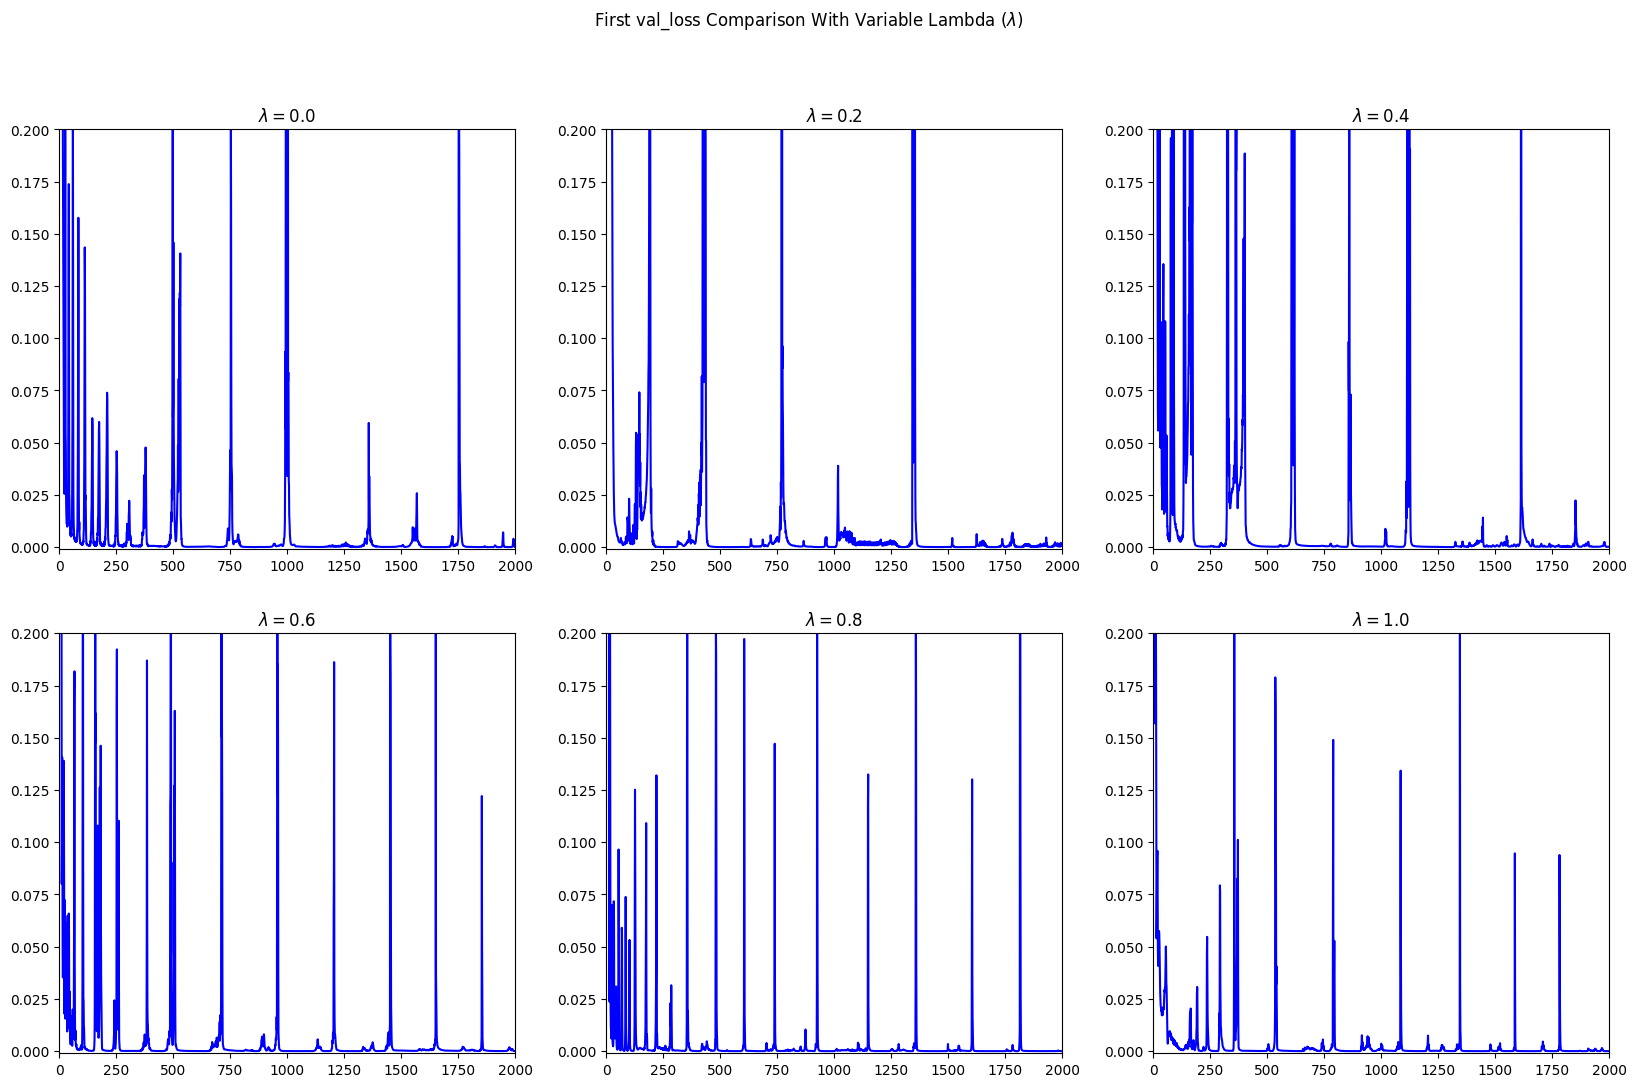

In [29]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 12))
fig.suptitle('First val_loss Comparison With Variable Lambda ($\lambda$)')
ax1.plot(v00[1,:], color='blue')
ax1.axis([0, 2000, -0.001, 0.2])
ax1.set_title('$\lambda=0.0$')
ax2.plot(v02[1,:], color='blue')
ax2.axis([0, 2000, -0.001, 0.2])
ax2.set_title('$\lambda=0.2$')
ax3.plot(v04[1,:], color='blue')
ax3.axis([0, 2000, -0.001, 0.2])
ax3.set_title('$\lambda=0.4$')
ax4.plot(v06[1,:], color='blue')
ax4.axis([0, 2000, -0.001, 0.2])
ax4.set_title('$\lambda=0.6$')
ax5.plot(v08[1,:], color='blue')
ax5.axis([0, 2000, -0.001, 0.2])
ax5.set_title('$\lambda=0.8$')
ax6.plot(v10[1,:], color='blue')
ax6.axis([0, 2000, -0.001, 0.2])
ax6.set_title('$\lambda=1.0$')

In [30]:
c00 = np.load('TrainPREDS_Lambda0.8_Pts18.npy')
c02 = np.load('TrainPREDS_Lambda0.8_Pts20.npy')
c04 = np.load('TrainPREDS_Lambda0.8_Pts22.npy')
c06 = np.load('TrainPREDS_Lambda0.8_Pts24.npy')
c08 = np.load('TrainPREDS_Lambda0.8_Pts26.npy') 
c10 = np.load('TrainPREDS_Lambda0.8_Pts28.npy')
y_contours = [c00, c02, c04, c06, c08, c10]

l18 = np.load('TrainPREDS_Lambda0.8_Pts18.npy')
l20 = np.load('TrainPREDS_Lambda0.8_Pts20.npy')
l22 = np.load('TrainPREDS_Lambda0.8_Pts22.npy')
l24 = np.load('TrainPREDS_Lambda0.8_Pts24.npy')
l26 = np.load('TrainPREDS_Lambda0.8_Pts26.npy') 
l28 = np.load('TrainPREDS_Lambda0.8_Pts28.npy')
y_lzero = [l18, l20, l22, l24, l26, l28]

## Raissi menciona que naturalmente las PINN deberian funcionar bien con pocos puntos, por lo que probaremos el mismo modelo de NN, con $\lambda=0.0$, disminuyendo puntos totales para descubrir el error del MSE al tener pocos datos

In [31]:
#Para 28 puntos
q1_28 = np.concatenate((np.linspace(1.35,5.0,19),np.linspace(5.0, 8, 9)))
q2_28 = np.concatenate((np.linspace(1.6,5.0,19),np.linspace(5.0, 8, 9))) 
#Para 26 puntos
q1_26 = np.concatenate((np.linspace(1.35,5.0,18),np.linspace(5.0, 8, 8))) 
q2_26 = np.concatenate((np.linspace(1.6,5.0,18),np.linspace(5.0, 8, 8))) 
#Para 24 puntos
q1_24 = np.concatenate((np.linspace(1.35,5.0,17),np.linspace(5.0, 8, 7))) 
q2_24 = np.concatenate((np.linspace(1.6,5.0,17),np.linspace(5.0, 8, 7))) 
#Para 22 puntos
q1_22 = np.concatenate((np.linspace(1.35,5.0,16),np.linspace(5.0, 8, 6))) 
q2_22 = np.concatenate((np.linspace(1.6,5.0,16),np.linspace(5.0, 8, 6))) 
#Para 20 puntos
q1_20 = np.concatenate((np.linspace(1.35,5.0,15),np.linspace(5.0, 8, 5))) 
q2_20 = np.concatenate((np.linspace(1.6,5.0,15),np.linspace(5.0, 8, 5))) 
#Para 18 puntos
q1_18 = np.concatenate((np.linspace(1.35,5.0,13),np.linspace(5.0, 8, 5))) 
q2_18 = np.concatenate((np.linspace(1.6,5.0,13),np.linspace(5.0, 8, 5)))


R1_eq = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
R2_eq = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
theta_eq = np.pi


(-0.1, 2.0, -0.1, 2.0)

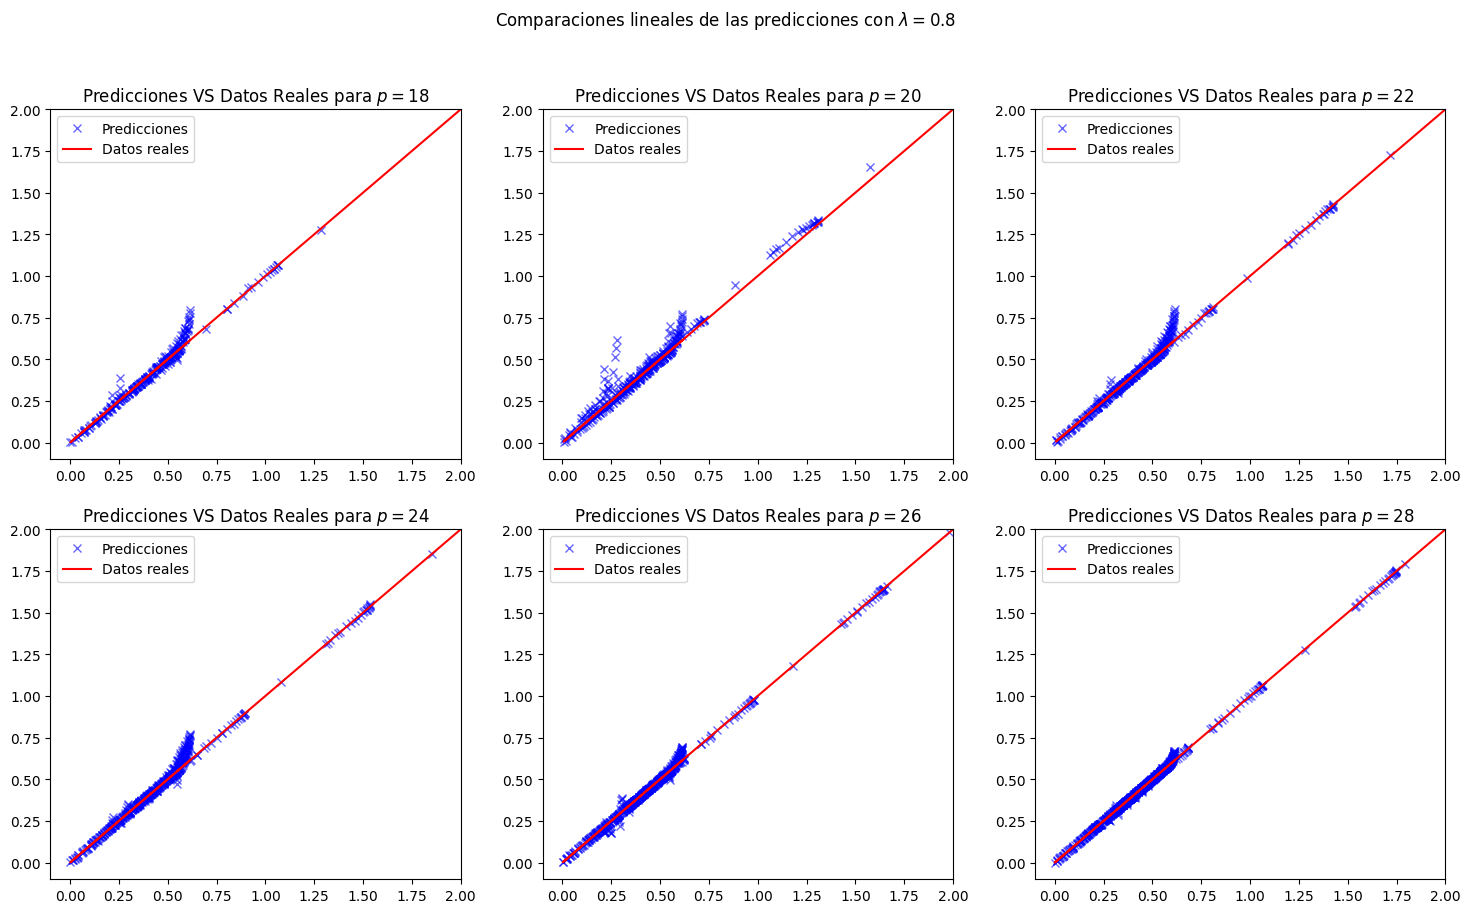

In [32]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Comparaciones lineales de las predicciones con $\lambda=0.8$')

ax1.plot(l18[0,:], l18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(l18[0,:], l18[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("Predicciones VS Datos Reales para $p=18$")
ax1.axis([-0.1,2,-0.1,2])
ax2.plot(l20[0,:], l20[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(l20[0,:], l20[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("Predicciones VS Datos Reales para $p=20$")
ax2.axis([-0.1,2,-0.1,2])
ax3.plot(l22[0,:], l22[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(l22[0,:], l22[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("Predicciones VS Datos Reales para $p=22$")
ax3.axis([-0.1,2,-0.1,2])
ax4.plot(l24[0,:], l24[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(l24[0,:], l24[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("Predicciones VS Datos Reales para $p=24$")
ax4.axis([-0.1,2,-0.1,2])
ax5.plot(l26[0,:], l26[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(l26[0,:], l26[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("Predicciones VS Datos Reales para $p=26$")
ax5.axis([-0.1,2,-0.1,2])
ax6.plot(l28[0,:], l28[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(l28[0,:], l28[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("Predicciones VS Datos Reales para $p=28$")
ax6.axis([-0.1,2,-0.1,2])

(2.0, 8.0, 1.8, 7.5)

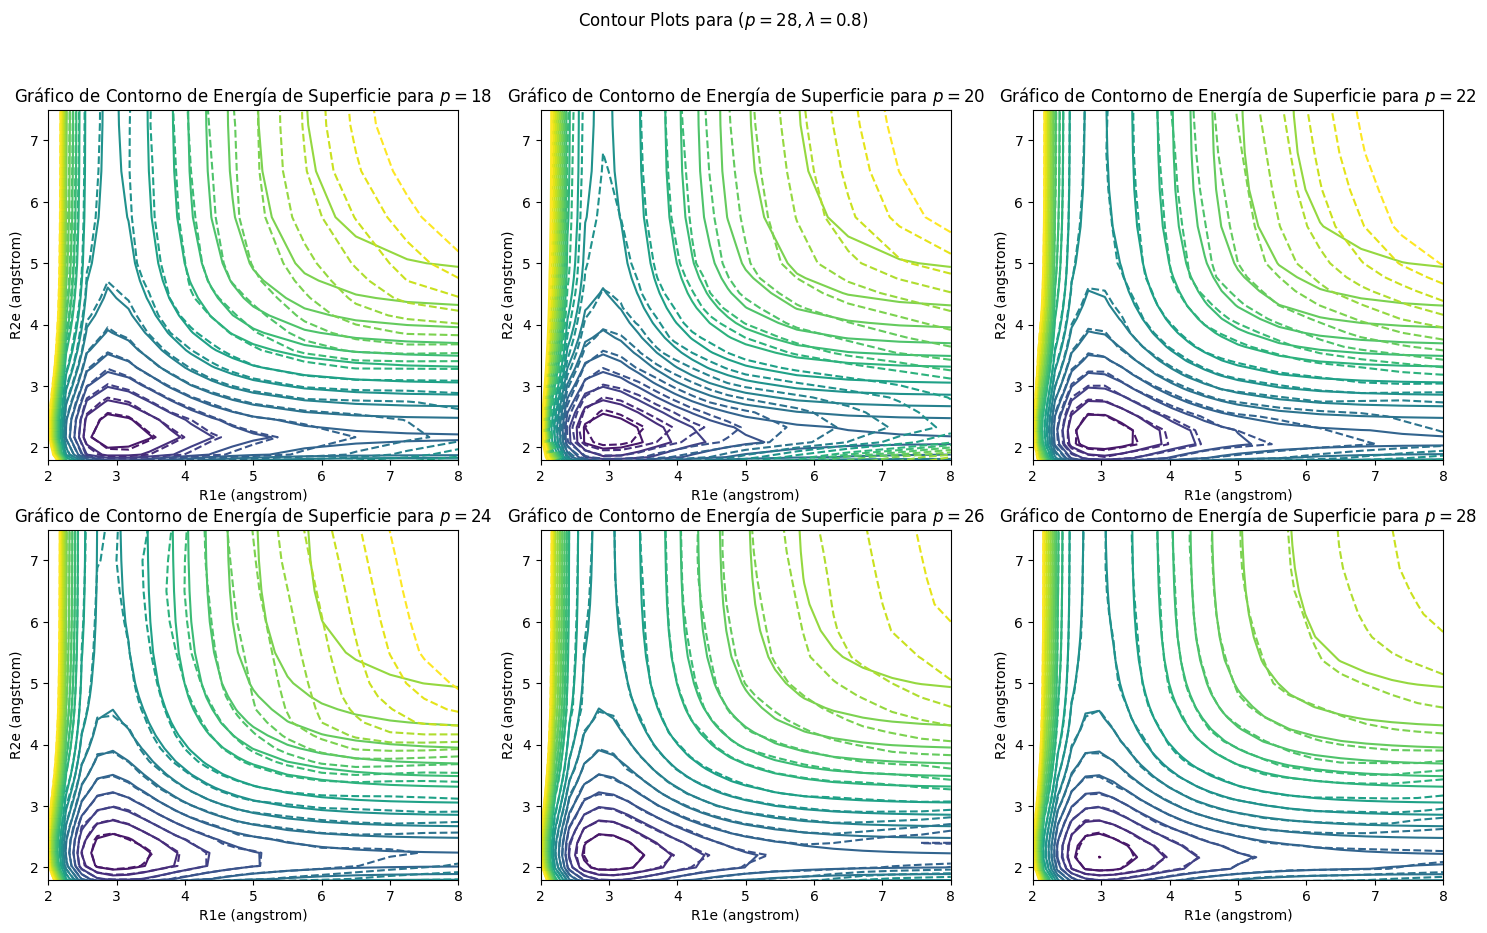

In [33]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Contour Plots para $(p=28,\lambda=0.8)$')

#Lectura de los datos para contornos
R2e18, R1e18 = np.meshgrid(q2_18, q1_18)
R2e20, R1e20 = np.meshgrid(q2_20, q1_20)
R2e22, R1e22 = np.meshgrid(q2_22, q1_22)
R2e24, R1e24 = np.meshgrid(q2_24, q1_24)
R2e26, R1e26 = np.meshgrid(q2_26, q1_26)
R2e28, R1e28 = np.meshgrid(q2_28, q1_28)

energia_superficie18 = np.vectorize(V)(R1e18, R2e18, np.pi) # type: ignore
energia_superficie20 = np.vectorize(V)(R1e20, R2e20, np.pi) # type: ignore
energia_superficie22 = np.vectorize(V)(R1e22, R2e22, np.pi) # type: ignore
energia_superficie24 = np.vectorize(V)(R1e24, R2e24, np.pi) # type: ignore
energia_superficie26 = np.vectorize(V)(R1e26, R2e26, np.pi) # type: ignore
energia_superficie28 = np.vectorize(V)(R1e28, R2e28, np.pi) # type: ignore

energia_superficie0 =  l18[1,:].reshape(18,18)
energia_superficie2 =  l20[1,:].reshape(20,20)
energia_superficie4 =  l22[1,:].reshape(22,22)
energia_superficie6 =  l24[1,:].reshape(24,24)
energia_superficie8 =  l26[1,:].reshape(26,26)
energia_superficie1 =  l28[1,:].reshape(28,28)

Ncontours = 20
level_min = 0.0
level_max = 0.7
levels0 = np.concatenate((np.linspace(level_min,0.4,Ncontours-10), np.linspace(0.45,level_max,10)))

#Plot de los contornos predichos vs real
ctreal = ax1.contour(R1e18, R2e18, energia_superficie18, levels0, vmin=level_min, vmax=level_max)
ctpred = ax1.contour(R1e18, R2e18, energia_superficie0, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax2.contour(R1e20, R2e20, energia_superficie20, levels0, vmin=level_min, vmax=level_max)
ctpred = ax2.contour(R1e20, R2e20, energia_superficie2, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax3.contour(R1e22, R2e22, energia_superficie22, levels0, vmin=level_min, vmax=level_max)
ctpred = ax3.contour(R1e22, R2e22, energia_superficie4, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax4.contour(R1e24, R2e24, energia_superficie24, levels0, vmin=level_min, vmax=level_max)
ctpred = ax4.contour(R1e24, R2e24, energia_superficie6, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax5.contour(R1e26, R2e26, energia_superficie26, levels0, vmin=level_min, vmax=level_max)
ctpred = ax5.contour(R1e26, R2e26, energia_superficie8, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax6.contour(R1e28, R2e28, energia_superficie28, levels0, vmin=level_min, vmax=level_max)
ctpred = ax6.contour(R1e28, R2e28, energia_superficie1, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')

# Info de plots
ax1.set_xlabel('R1e (angstrom)')
ax1.set_ylabel('R2e (angstrom)')
ax1.set_title('Gráfico de Contorno de Energía de Superficie para $p=18$')
ax1.axis([2.0,8.0,1.8,7.5])
ax2.set_xlabel('R1e (angstrom)')
ax2.set_ylabel('R2e (angstrom)')
ax2.set_title('Gráfico de Contorno de Energía de Superficie para $p=20$')
ax2.axis([2.0,8.0,1.8,7.5])
ax3.set_xlabel('R1e (angstrom)')
ax3.set_ylabel('R2e (angstrom)')
ax3.set_title('Gráfico de Contorno de Energía de Superficie para $p=22$')
ax3.axis([2.0,8.0,1.8,7.5])
ax4.set_xlabel('R1e (angstrom)')
ax4.set_ylabel('R2e (angstrom)')
ax4.set_title('Gráfico de Contorno de Energía de Superficie para $p=24$')
ax4.axis([2.0,8.0,1.8,7.5])
ax5.set_xlabel('R1e (angstrom)')
ax5.set_ylabel('R2e (angstrom)')
ax5.set_title('Gráfico de Contorno de Energía de Superficie para $p=26$')
ax5.axis([2.0,8.0,1.8,7.5])
ax6.set_xlabel('R1e (angstrom)')
ax6.set_ylabel('R2e (angstrom)')
ax6.set_title('Gráfico de Contorno de Energía de Superficie para $p=28$')
ax6.axis([2.0,8.0,1.8,7.5])

In [34]:
#l04p18 = np.load('TrainPREDS_Lambda0.4_Pts18.npy')
#l18 = np.load('TrainPREDS_Lambda0_Pts18.npy')
#
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 10))
#fig.suptitle('Comparaciones lineales de las predicciones con $\lambda=0.8$')
#
#ax1.plot(l18[0,:], l18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
#ax1.plot(l18[0,:], l18[0,:], color='red', label='Datos reales')
#ax1.legend()
#ax1.set_title("Predicciones VS Datos Reales para $p=18$ lambda=0")
#ax1.axis([-0.1,2,-0.1,2])
#ax2.plot(l04p18[0,:], l04p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
#ax2.plot(l04p18[0,:], l04p18[0,:], color='red', label='Datos reales')
#ax2.axis([-0.1,2,-0.1,2])
#
#ax2.set_title("Predicciones VS Datos Reales para $p=18$ lambda=0.4")
#ax2.legend()

(-0.1, 2.0, -0.1, 2.0)

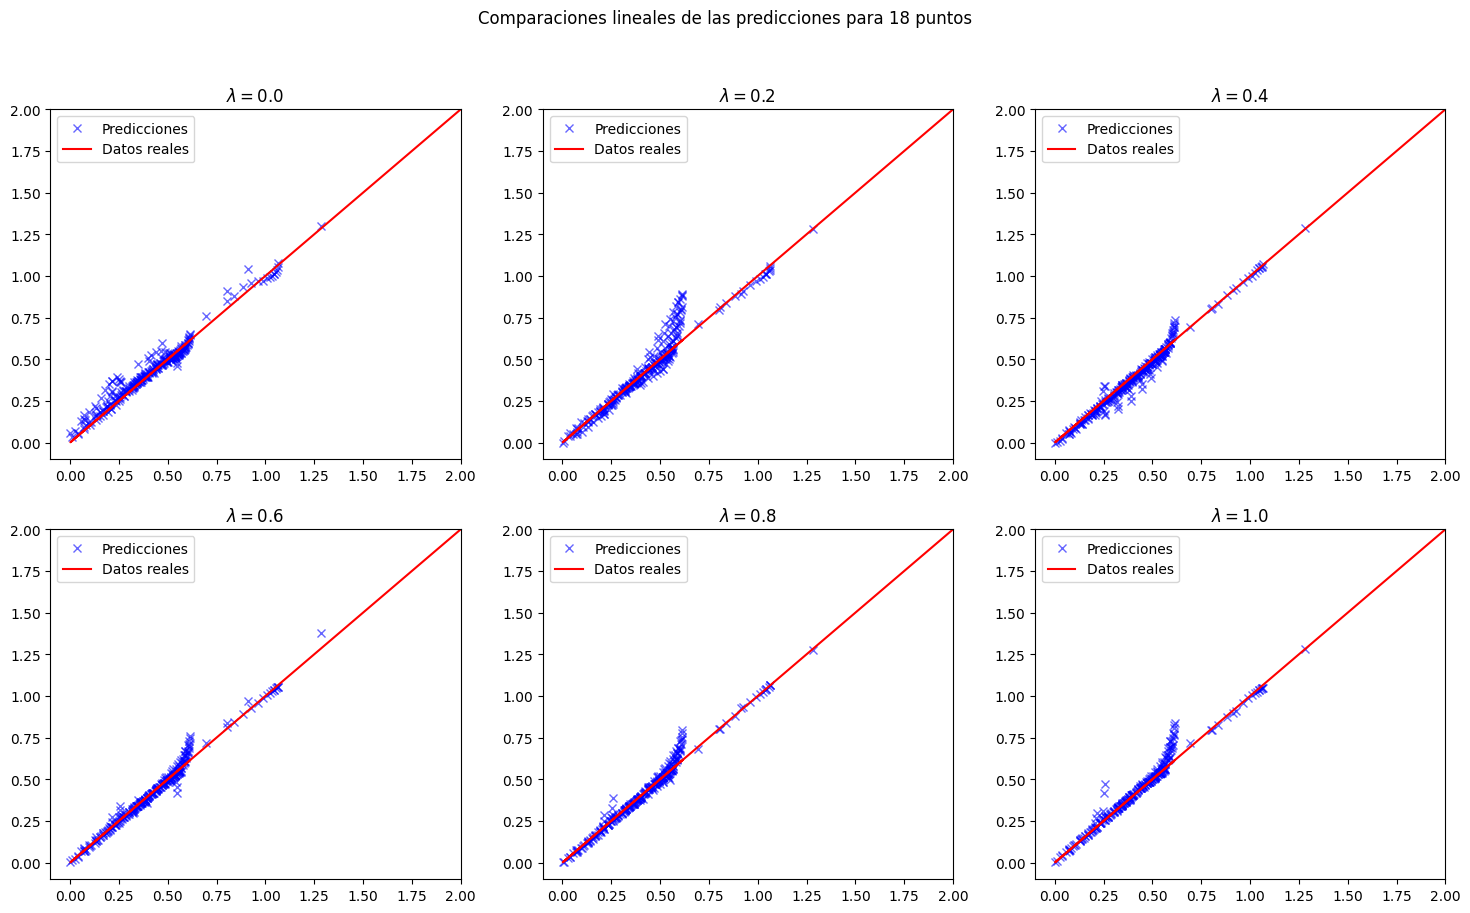

In [35]:
l00p18 = np.load('TrainPREDS_Lambda0.0_Pts18.npy')
l02p18 = np.load('TrainPREDS_Lambda0.2_Pts18.npy')
l04p18 = np.load('TrainPREDS_Lambda0.4_Pts18.npy')
l06p18 = np.load('TrainPREDS_Lambda0.6_Pts18.npy')
l08p18 = np.load('TrainPREDS_Lambda0.8_Pts18.npy') 
l10p18 = np.load('TrainPREDS_Lambda1.0_Pts18.npy')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Comparaciones lineales de las predicciones para 18 puntos')

ax1.plot(l00p18[0,:], l00p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(l00p18[0,:], l00p18[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("$\lambda=0.0$")
ax1.axis([-0.1,2,-0.1,2])
ax2.plot(l02p18[0,:], l02p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(l02p18[0,:], l02p18[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("$\lambda=0.2$")
ax2.axis([-0.1,2,-0.1,2])
ax3.plot(l04p18[0,:], l04p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(l04p18[0,:], l04p18[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("$\lambda=0.4$")
ax3.axis([-0.1,2,-0.1,2])
ax4.plot(l06p18[0,:], l06p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(l06p18[0,:], l06p18[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("$\lambda=0.6$")
ax4.axis([-0.1,2,-0.1,2])
ax5.plot(l08p18[0,:], l08p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(l08p18[0,:], l08p18[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("$\lambda=0.8$")
ax5.axis([-0.1,2,-0.1,2])
ax6.plot(l10p18[0,:], l10p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(l10p18[0,:], l10p18[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("$\lambda=1.0$")
ax6.axis([-0.1,2,-0.1,2])

(-0.1, 2.0, -0.1, 2.0)

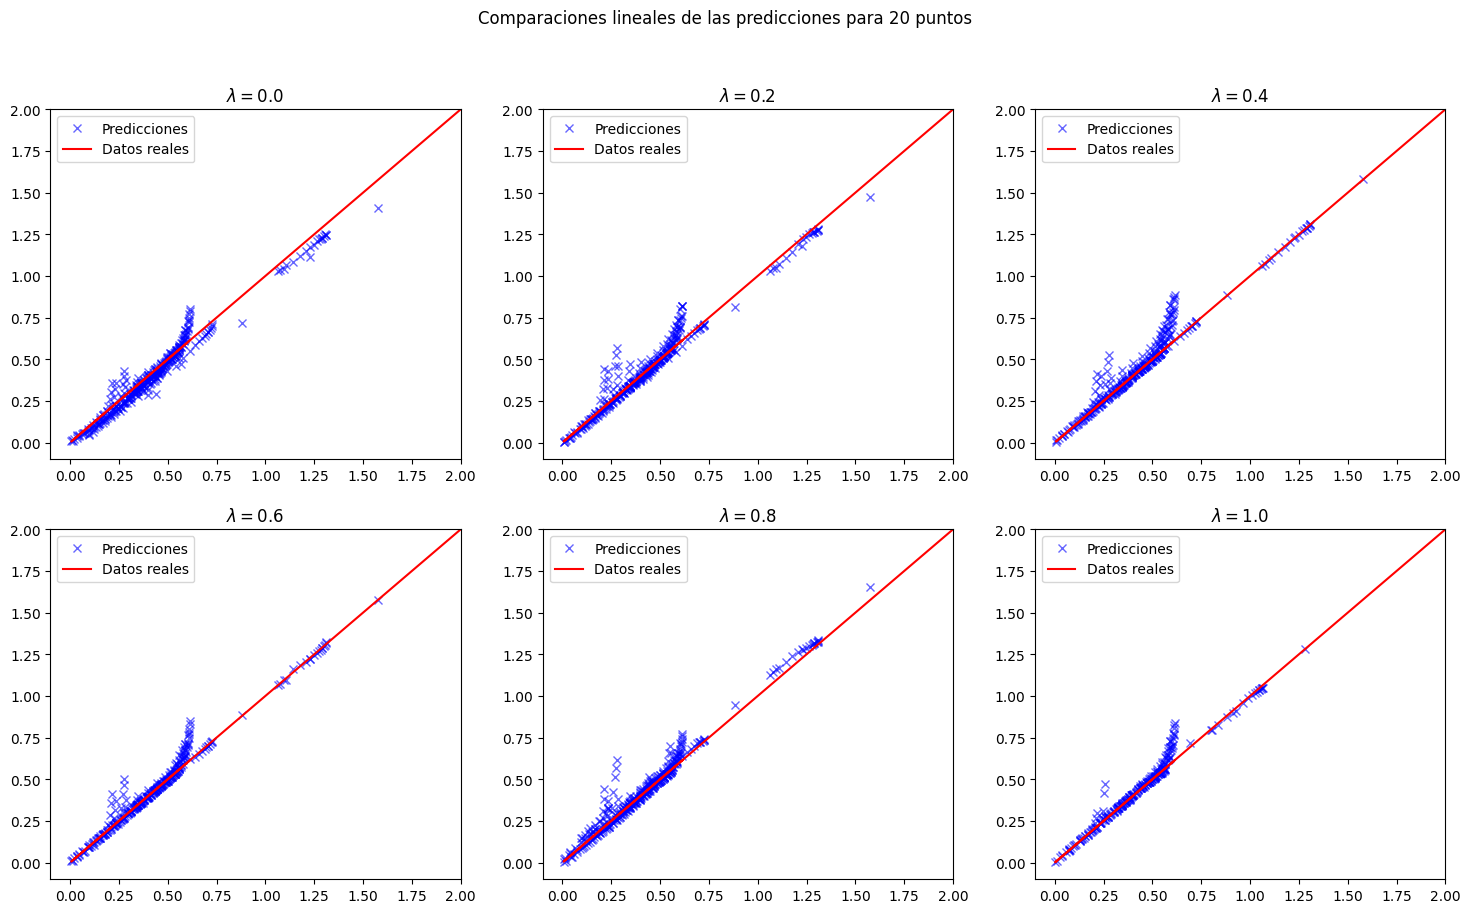

In [36]:
l00p20 = np.load('TrainPREDS_Lambda0.0_Pts20.npy')
l02p20 = np.load('TrainPREDS_Lambda0.2_Pts20.npy')
l04p20 = np.load('TrainPREDS_Lambda0.4_Pts20.npy')
l06p20 = np.load('TrainPREDS_Lambda0.6_Pts20.npy')
l08p20 = np.load('TrainPREDS_Lambda0.8_Pts20.npy') 
l10p20 = np.load('TrainPREDS_Lambda1.0_Pts20.npy')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Comparaciones lineales de las predicciones para 20 puntos')

ax1.plot(l00p20[0,:], l00p20[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(l00p20[0,:], l00p20[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("$\lambda=0.0$")
ax1.axis([-0.1,2,-0.1,2])
ax2.plot(l02p20[0,:], l02p20[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(l02p20[0,:], l02p20[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("$\lambda=0.2$")
ax2.axis([-0.1,2,-0.1,2])
ax3.plot(l04p20[0,:], l04p20[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(l04p20[0,:], l04p20[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("$\lambda=0.4$")
ax3.axis([-0.1,2,-0.1,2])
ax4.plot(l06p20[0,:], l06p20[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(l06p20[0,:], l06p20[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("$\lambda=0.6$")
ax4.axis([-0.1,2,-0.1,2])
ax5.plot(l08p20[0,:], l08p20[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(l08p20[0,:], l08p20[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("$\lambda=0.8$")
ax5.axis([-0.1,2,-0.1,2])
ax6.plot(l10p18[0,:], l10p18[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(l10p18[0,:], l10p18[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("$\lambda=1.0$")
ax6.axis([-0.1,2,-0.1,2])

(-0.1, 2.0, -0.1, 2.0)

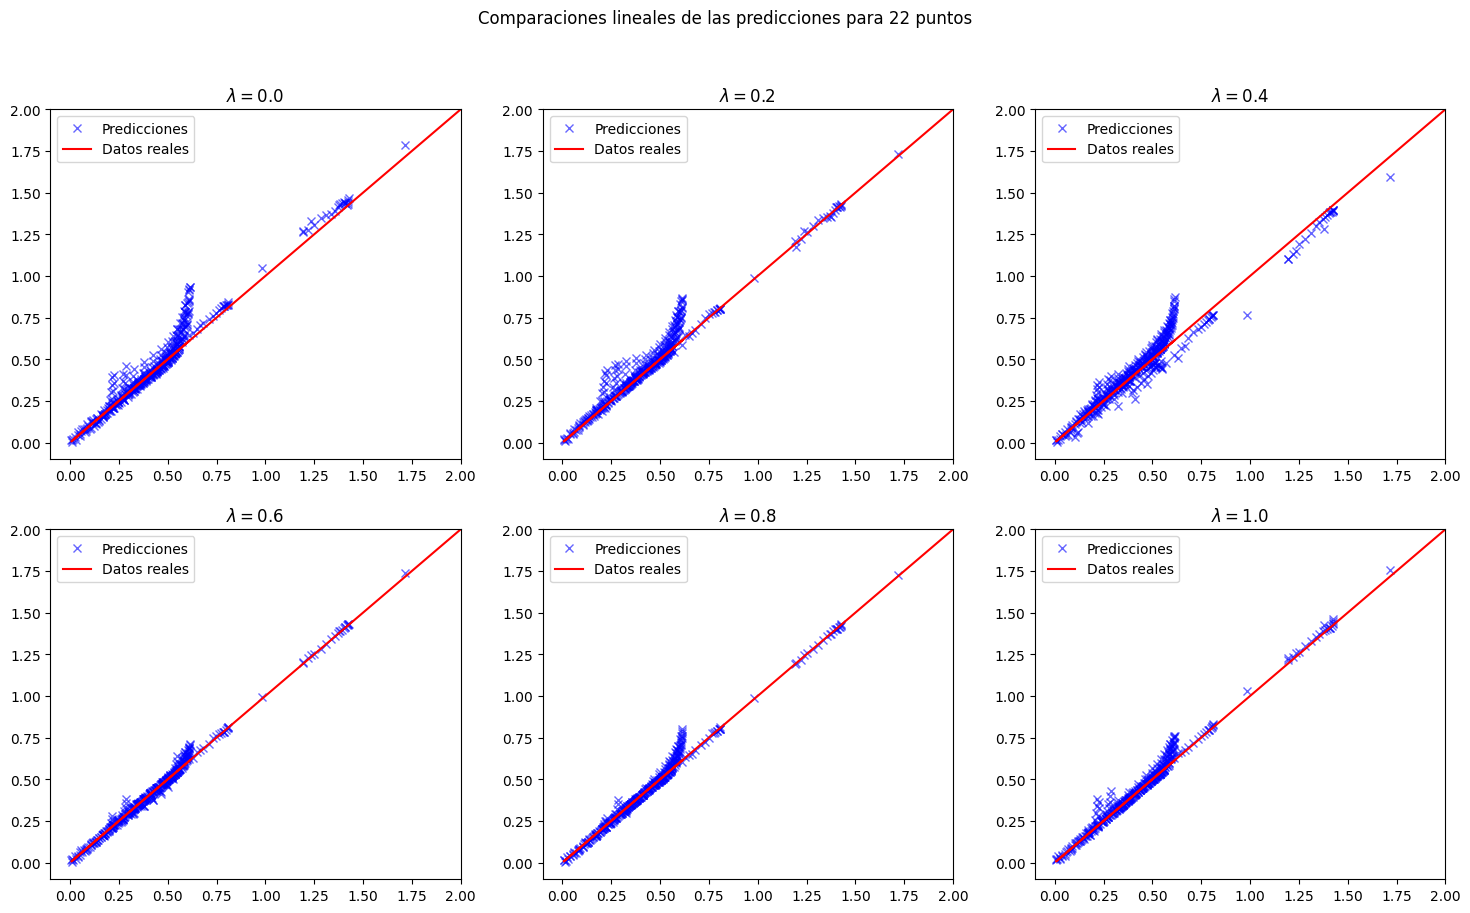

In [37]:
l00p22 = np.load('TrainPREDS_Lambda0.0_Pts22.npy')
l02p22 = np.load('TrainPREDS_Lambda0.2_Pts22.npy')
l04p22 = np.load('TrainPREDS_Lambda0.4_Pts22.npy')
l06p22 = np.load('TrainPREDS_Lambda0.6_Pts22.npy')
l08p22 = np.load('TrainPREDS_Lambda0.8_Pts22.npy') 
l10p22 = np.load('TrainPREDS_Lambda1.0_Pts22.npy')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Comparaciones lineales de las predicciones para 22 puntos')

ax1.plot(l00p22[0,:], l00p22[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(l00p22[0,:], l00p22[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("$\lambda=0.0$")
ax1.axis([-0.1,2,-0.1,2])
ax2.plot(l02p22[0,:], l02p22[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(l02p22[0,:], l02p22[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("$\lambda=0.2$")
ax2.axis([-0.1,2,-0.1,2])
ax3.plot(l04p22[0,:], l04p22[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(l04p22[0,:], l04p22[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("$\lambda=0.4$")
ax3.axis([-0.1,2,-0.1,2])
ax4.plot(l06p22[0,:], l06p22[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(l06p22[0,:], l06p22[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("$\lambda=0.6$")
ax4.axis([-0.1,2,-0.1,2])
ax5.plot(l08p22[0,:], l08p22[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(l08p22[0,:], l08p22[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("$\lambda=0.8$")
ax5.axis([-0.1,2,-0.1,2])
ax6.plot(l10p22[0,:], l10p22[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(l10p22[0,:], l10p22[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("$\lambda=1.0$")
ax6.axis([-0.1,2,-0.1,2])

(-0.1, 2.0, -0.1, 2.0)

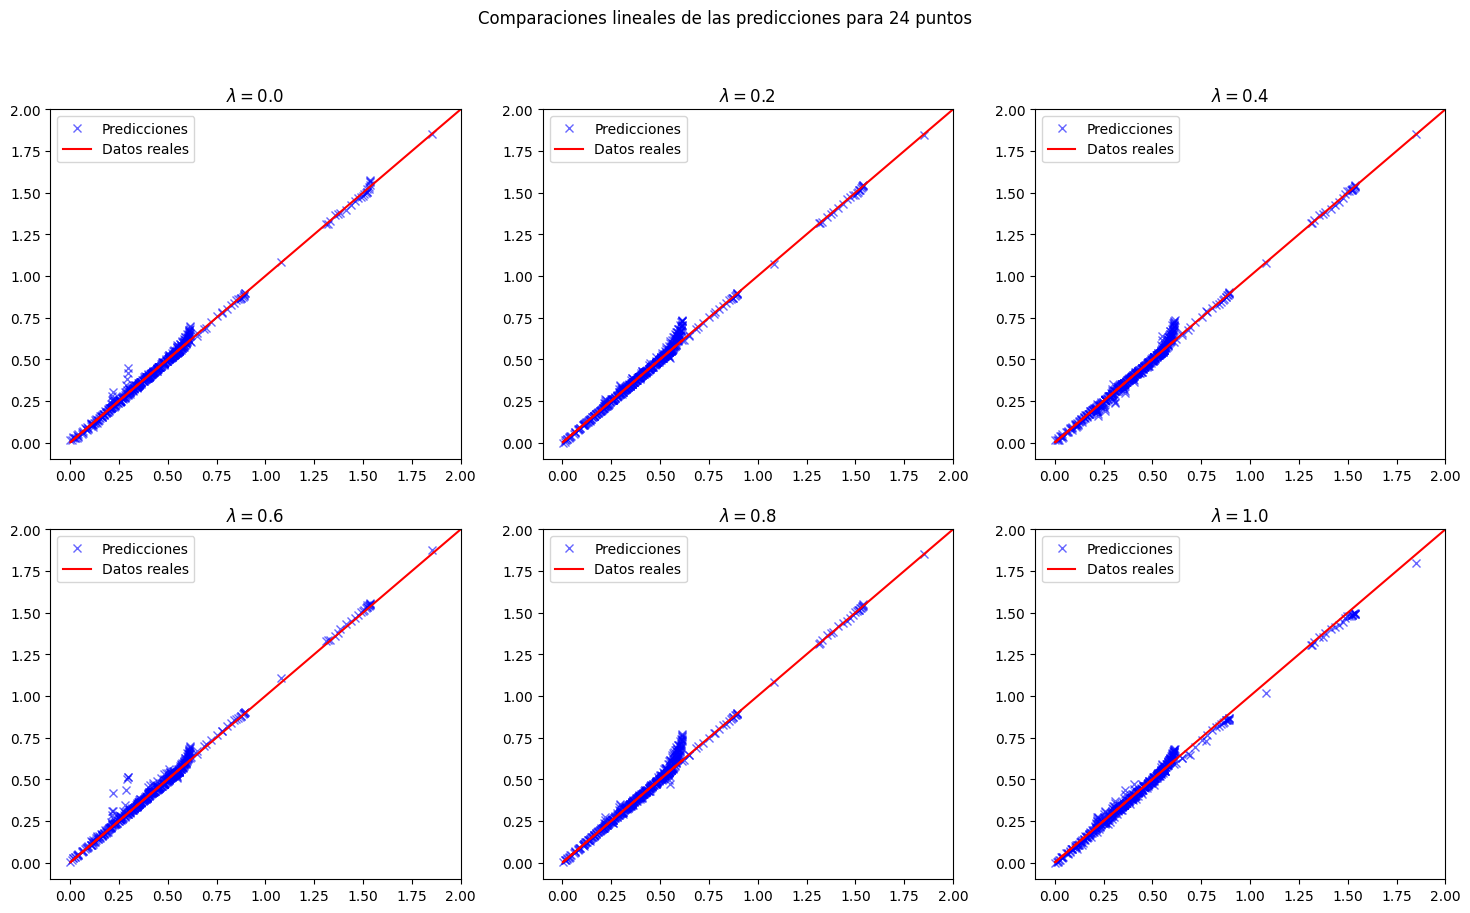

In [38]:
l00p24 = np.load('TrainPREDS_Lambda0.0_Pts24.npy')
l02p24 = np.load('TrainPREDS_Lambda0.2_Pts24.npy')
l04p24 = np.load('TrainPREDS_Lambda0.4_Pts24.npy')
l06p24 = np.load('TrainPREDS_Lambda0.6_Pts24.npy')
l08p24 = np.load('TrainPREDS_Lambda0.8_Pts24.npy') 
l10p24 = np.load('TrainPREDS_Lambda1.0_Pts24.npy')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Comparaciones lineales de las predicciones para 24 puntos')

ax1.plot(l00p24[0,:], l00p24[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(l00p24[0,:], l00p24[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("$\lambda=0.0$")
ax1.axis([-0.1,2,-0.1,2])
ax2.plot(l02p24[0,:], l02p24[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(l02p24[0,:], l02p24[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("$\lambda=0.2$")
ax2.axis([-0.1,2,-0.1,2])
ax3.plot(l04p24[0,:], l04p24[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(l04p24[0,:], l04p24[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("$\lambda=0.4$")
ax3.axis([-0.1,2,-0.1,2])
ax4.plot(l06p24[0,:], l06p24[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(l06p24[0,:], l06p24[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("$\lambda=0.6$")
ax4.axis([-0.1,2,-0.1,2])
ax5.plot(l08p24[0,:], l08p24[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(l08p24[0,:], l08p24[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("$\lambda=0.8$")
ax5.axis([-0.1,2,-0.1,2])
ax6.plot(l10p24[0,:], l10p24[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(l10p24[0,:], l10p24[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("$\lambda=1.0$")
ax6.axis([-0.1,2,-0.1,2])

(-0.1, 2.0, -0.1, 2.0)

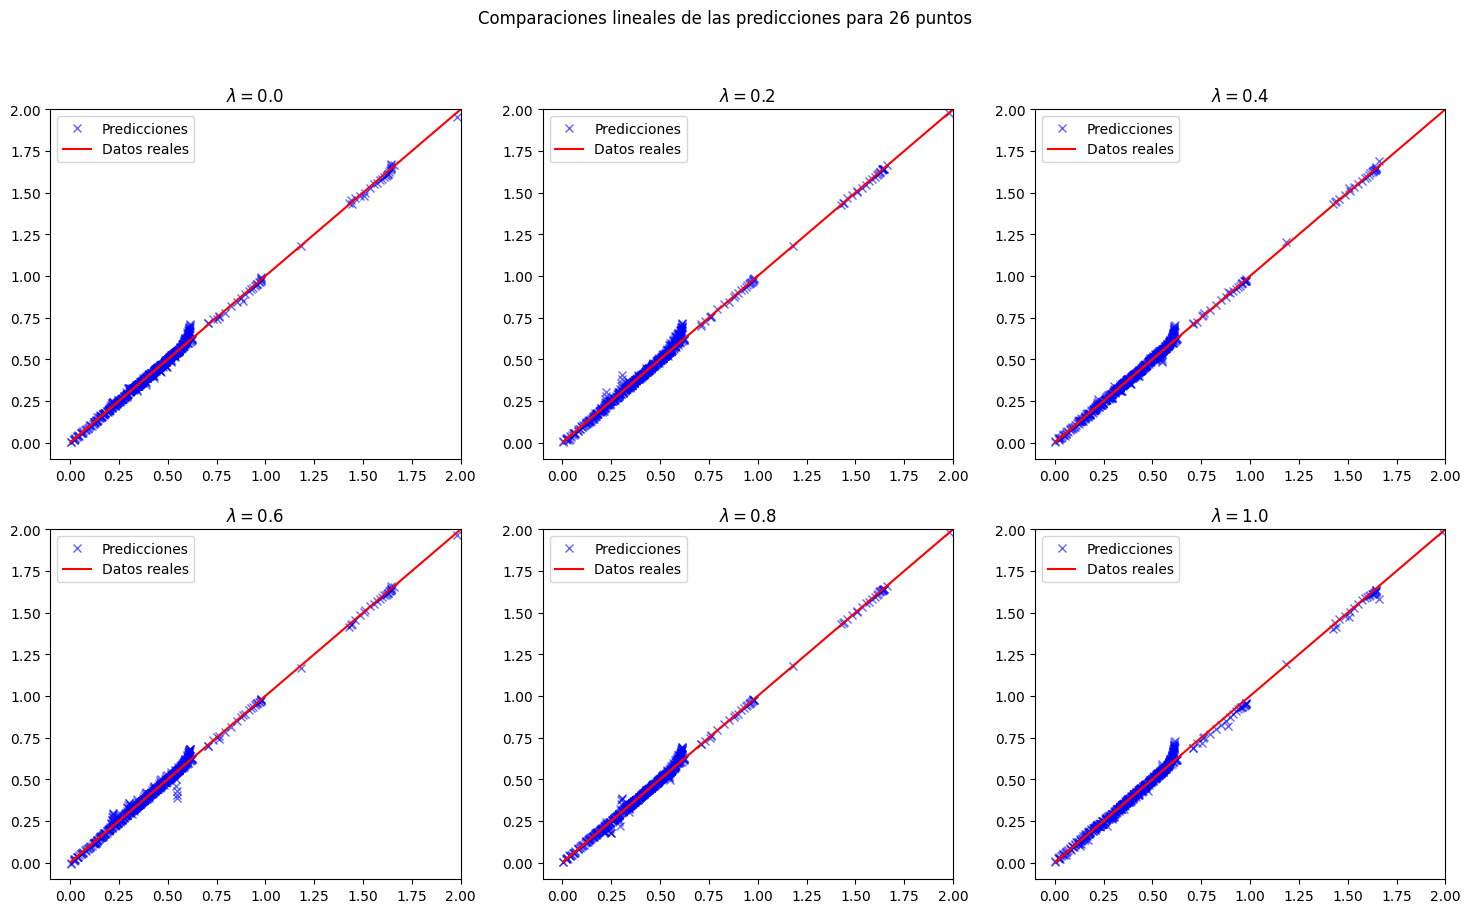

In [39]:
l00p26 = np.load('TrainPREDS_Lambda0.0_Pts26.npy')
l02p26 = np.load('TrainPREDS_Lambda0.2_Pts26.npy')
l04p26 = np.load('TrainPREDS_Lambda0.4_Pts26.npy')
l06p26 = np.load('TrainPREDS_Lambda0.6_Pts26.npy')
l08p26 = np.load('TrainPREDS_Lambda0.8_Pts26.npy') 
l10p26 = np.load('TrainPREDS_Lambda1.0_Pts26.npy')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Comparaciones lineales de las predicciones para 26 puntos')
    
ax1.plot(l00p26[0,:], l00p26[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(l00p26[0,:], l00p26[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("$\lambda=0.0$")
ax1.axis([-0.1,2,-0.1,2])
ax2.plot(l02p26[0,:], l02p26[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(l02p26[0,:], l02p26[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("$\lambda=0.2$")
ax2.axis([-0.1,2,-0.1,2])
ax3.plot(l04p26[0,:], l04p26[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(l04p26[0,:], l04p26[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("$\lambda=0.4$")
ax3.axis([-0.1,2,-0.1,2])
ax4.plot(l06p26[0,:], l06p26[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(l06p26[0,:], l06p26[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("$\lambda=0.6$")
ax4.axis([-0.1,2,-0.1,2])
ax5.plot(l08p26[0,:], l08p26[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(l08p26[0,:], l08p26[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("$\lambda=0.8$")
ax5.axis([-0.1,2,-0.1,2])
ax6.plot(l10p26[0,:], l10p26[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(l10p26[0,:], l10p26[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("$\lambda=1.0$")
ax6.axis([-0.1,2,-0.1,2])

(-0.1, 2.0, -0.1, 2.0)

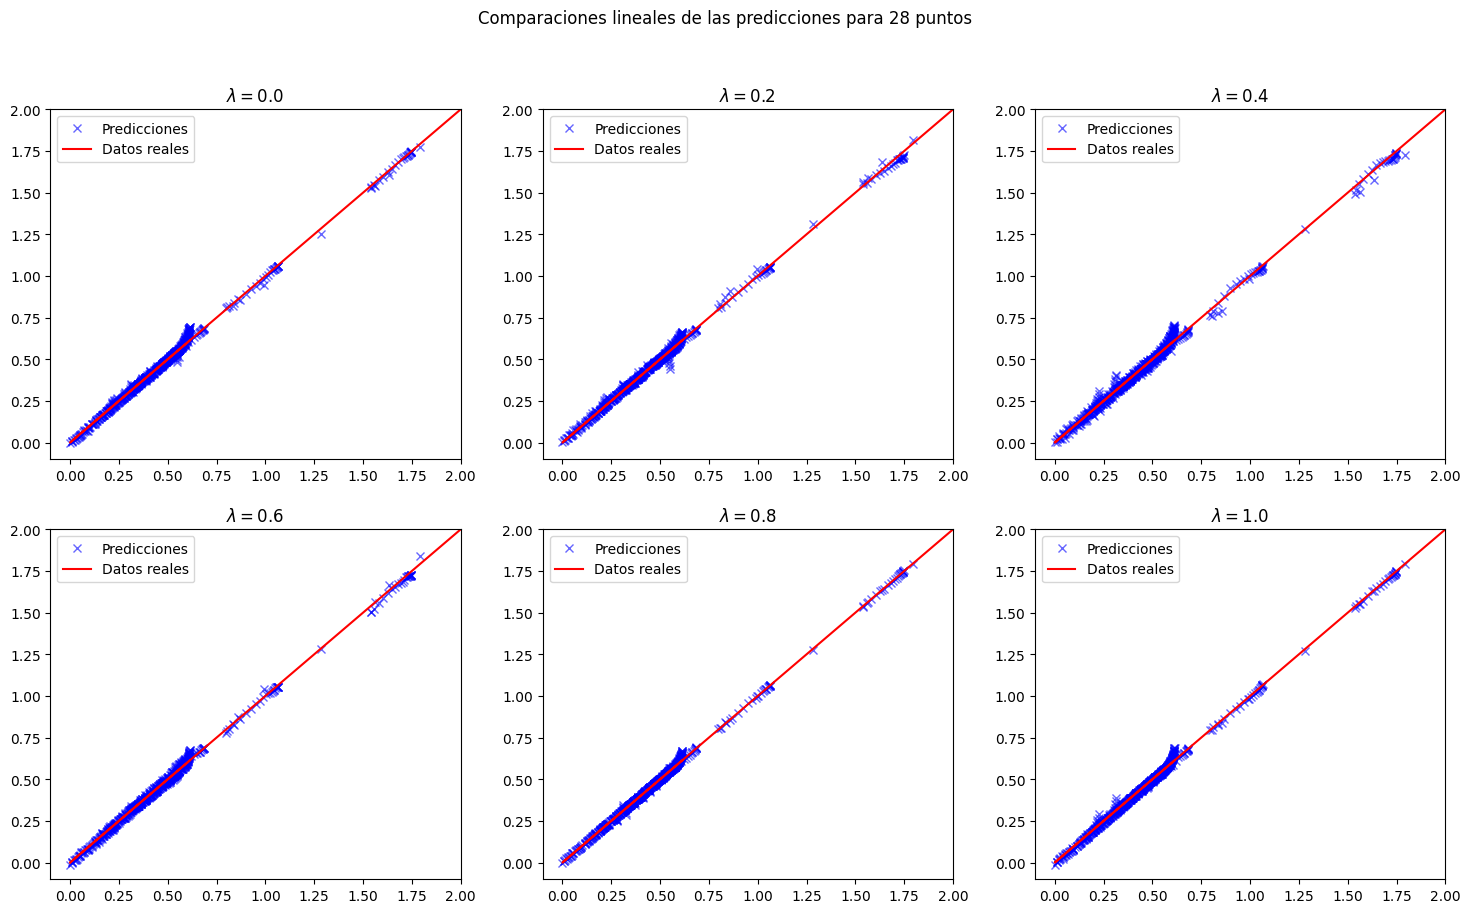

In [40]:
l00p28 = np.load('TrainPREDS_Lambda0.0_Pts28.npy')
l02p28 = np.load('TrainPREDS_Lambda0.2_Pts28.npy')
l04p28 = np.load('TrainPREDS_Lambda0.4_Pts28.npy')
l06p28 = np.load('TrainPREDS_Lambda0.6_Pts28.npy')
l08p28 = np.load('TrainPREDS_Lambda0.8_Pts28.npy') 
l10p28 = np.load('TrainPREDS_Lambda1.0_Pts28.npy')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Comparaciones lineales de las predicciones para 28 puntos')

ax1.plot(l00p28[0,:], l00p28[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(l00p28[0,:], l00p28[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("$\lambda=0.0$")
ax1.axis([-0.1,2,-0.1,2])
ax2.plot(l02p28[0,:], l02p28[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(l02p28[0,:], l02p28[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("$\lambda=0.2$")
ax2.axis([-0.1,2,-0.1,2])
ax3.plot(l04p28[0,:], l04p28[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(l04p28[0,:], l04p28[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("$\lambda=0.4$")
ax3.axis([-0.1,2,-0.1,2])
ax4.plot(l06p28[0,:], l06p28[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(l06p28[0,:], l06p28[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("$\lambda=0.6$")
ax4.axis([-0.1,2,-0.1,2])
ax5.plot(l08p28[0,:], l08p28[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(l08p28[0,:], l08p28[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("$\lambda=0.8$")
ax5.axis([-0.1,2,-0.1,2])
ax6.plot(l10p28[0,:], l10p28[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(l10p28[0,:], l10p28[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("$\lambda=1.0$")
ax6.axis([-0.1,2,-0.1,2])

(2.0, 8.0, 1.8, 7.5)

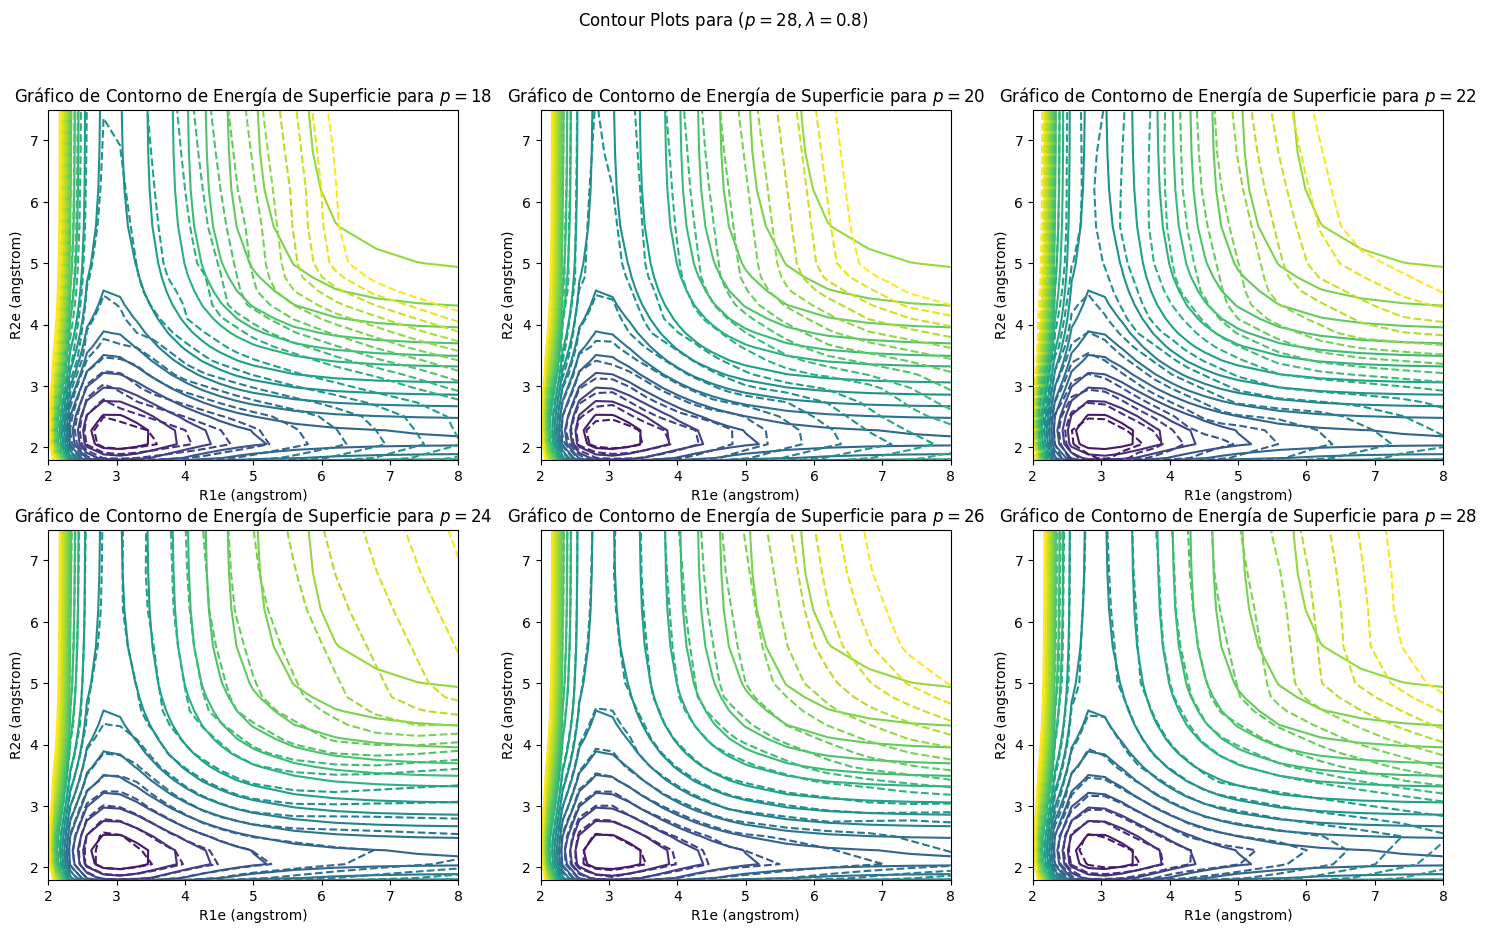

In [43]:
c00p22 = np.load('TrainPREDS_Lambda0.0_Pts22.npy')
c02p22 = np.load('TrainPREDS_Lambda0.2_Pts22.npy')
c04p22 = np.load('TrainPREDS_Lambda0.4_Pts22.npy')
c06p22 = np.load('TrainPREDS_Lambda0.6_Pts22.npy')
c08p22 = np.load('TrainPREDS_Lambda0.8_Pts22.npy') 
c10p22 = np.load('TrainPREDS_Lambda1.0_Pts22.npy')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 10))
fig.suptitle('Contour Plots para $(p=28,\lambda=0.8)$')

#Lectura de los datos para contornos
R2e22, R1e22 = np.meshgrid(q2_22, q1_22)
energia_superficie22 = np.vectorize(V)(R1e22, R2e22, np.pi) # type: ignore

energia_superficie0 =  c00p22[1,:].reshape(22,22)
energia_superficie2 =  c02p22[1,:].reshape(22,22)
energia_superficie4 =  c04p22[1,:].reshape(22,22)
energia_superficie6 =  c06p22[1,:].reshape(22,22)
energia_superficie8 =  c08p22[1,:].reshape(22,22)
energia_superficie1 =  c10p22[1,:].reshape(22,22)

Ncontours = 20
level_min = 0.0
level_max = 0.7
levels0 = np.concatenate((np.linspace(level_min,0.4,Ncontours-10), np.linspace(0.45,level_max,10)))

#Plot de los contornos predichos vs real
ctreal = ax1.contour(R1e22, R2e22, energia_superficie18, levels0, vmin=level_min, vmax=level_max)
ctpred = ax1.contour(R1e22, R2e22, energia_superficie0, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax2.contour(R1e22, R2e22, energia_superficie20, levels0, vmin=level_min, vmax=level_max)
ctpred = ax2.contour(R1e22, R2e22, energia_superficie2, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax3.contour(R1e22, R2e22, energia_superficie22, levels0, vmin=level_min, vmax=level_max)
ctpred = ax3.contour(R1e22, R2e22, energia_superficie4, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax4.contour(R1e22, R2e22, energia_superficie24, levels0, vmin=level_min, vmax=level_max)
ctpred = ax4.contour(R1e22, R2e22, energia_superficie6, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax5.contour(R1e22, R2e22, energia_superficie26, levels0, vmin=level_min, vmax=level_max)
ctpred = ax5.contour(R1e22, R2e22, energia_superficie8, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax6.contour(R1e22, R2e22, energia_superficie28, levels0, vmin=level_min, vmax=level_max)
ctpred = ax6.contour(R1e22, R2e22, energia_superficie1, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')

# Info de plots
ax1.set_xlabel('R1e (angstrom)')
ax1.set_ylabel('R2e (angstrom)')
ax1.set_title('Gráfico de Contorno de Energía de Superficie para $p=18$')
ax1.axis([2.0,8.0,1.8,7.5])
ax2.set_xlabel('R1e (angstrom)')
ax2.set_ylabel('R2e (angstrom)')
ax2.set_title('Gráfico de Contorno de Energía de Superficie para $p=20$')
ax2.axis([2.0,8.0,1.8,7.5])
ax3.set_xlabel('R1e (angstrom)')
ax3.set_ylabel('R2e (angstrom)')
ax3.set_title('Gráfico de Contorno de Energía de Superficie para $p=22$')
ax3.axis([2.0,8.0,1.8,7.5])
ax4.set_xlabel('R1e (angstrom)')
ax4.set_ylabel('R2e (angstrom)')
ax4.set_title('Gráfico de Contorno de Energía de Superficie para $p=24$')
ax4.axis([2.0,8.0,1.8,7.5])
ax5.set_xlabel('R1e (angstrom)')
ax5.set_ylabel('R2e (angstrom)')
ax5.set_title('Gráfico de Contorno de Energía de Superficie para $p=26$')
ax5.axis([2.0,8.0,1.8,7.5])
ax6.set_xlabel('R1e (angstrom)')
ax6.set_ylabel('R2e (angstrom)')
ax6.set_title('Gráfico de Contorno de Energía de Superficie para $p=28$')
ax6.axis([2.0,8.0,1.8,7.5])